In [1]:
# import libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import packages from scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree

# import SMOTE for handling imbalance training data
from imblearn.over_sampling import SMOTE

In [2]:
# Set environment variables
import os
os.environ['KAGGLE_USERNAME'] = 'oluwolekosilepalmer'
os.environ['KAGGLE_KEY'] = '3107de81e7aea534ac9bee6ac8c3cfc2'

# setup api and download datasets from kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kartik2112/fraud-detection', path='./', unzip=True)

# Load data
train_data = pd.read_csv('fraudTrain.csv')
test_data = pd.read_csv('fraudTest.csv')

print(f"train_data shape: {train_data.shape}\ntest_data shape: {test_data.shape}")

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
train_data shape: (1296675, 23)
test_data shape: (555719, 23)


In [3]:
pd.set_option('display.max_columns', None) # adjusts the settings to display all columns
train_data.head() # inspect loaded data
# test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
# calculate the test_size
print(f"test_size = {(test_data.shape[0]/(train_data.shape[0] + test_data.shape[0]))*100:.2f}%")
print(f"dataset_size = {train_data.shape[0] + test_data.shape[0]}")

test_size = 30.00%
dataset_size = 1852394


In [5]:
# review the data types of each column in the data
print(f"train_data data types:\n{train_data.dtypes}")
print(f"\ntest_data data types:\n{test_data.dtypes}")

train_data data types:
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

test_data data types:
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt             

**FEATURE ENGINEERING**
.
.
.

In [6]:
# define function to cast transaction time column(s) to datetime type
def col_to_datetime(data:pd.DataFrame, col_names:list):
  """
  ThiS function convertS transaction time column(s) from object data type to datetime data type.
  It takes two inputs:
  - the data (a pandas DataFrame)
  - and a list of the transaction time columns (strings)
  It further extract the hour, day, and month of each transaction was made from the transaction time column(s) and adds them as new columns or features.
  It does not return anything as it updates the data directly.
  """
  # convert each element in col_names to datetime format
  for name in col_names:
    data[name] = pd.to_datetime(data[name])

  # create new columns for hour, day, and month
  data['hour'] = data[name].dt.hour
  data['day'] = data[name].dt.day
  data['month'] = data[name].dt.month

  # drop the original transaction time column
  for name in col_names:
    data.drop(name, axis=1, inplace=True, errors='ignore')

In [7]:
# call the function on train_data and test_data
col_to_datetime(test_data, ['trans_date_trans_time'])
col_to_datetime(train_data, ['trans_date_trans_time'])

In [8]:
# split train_data and test_data into X (features) and y (target)
X_train = train_data.drop('is_fraud', axis=1)
y_train = train_data['is_fraud']

X_test = test_data.drop('is_fraud', axis=1)
y_test = test_data['is_fraud']

**ADDRESSING CLASS IMBALANCE USING SMOTE**
.
.
.

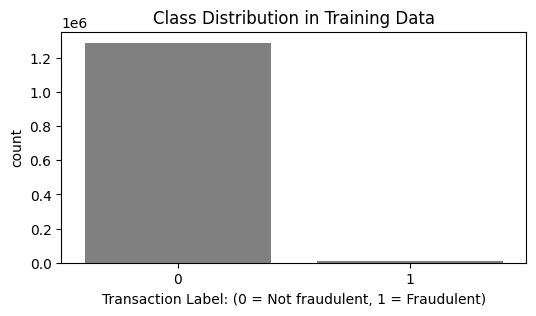

In [10]:
# check if training data is imbalanced
plt.figure(figsize=(6,3))
sns.countplot(data=train_data, x='is_fraud', color='grey')
plt.title("Class Distribution in Training Data")
plt.xlabel("Transaction Label: (0 = Not fraudulent, 1 = Fraudulent)")
plt.ylabel("count")
plt.show()

In [14]:
# encode categorical variables using LabelEncoder
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()
for col in categorical_cols:
    # fit LabelEncoder on the union of train and test data to avoid unseen labels
    combined = pd.concat([X_train[col], X_test[col]])
    label_encoder.fit(combined)

    # transform both train and test data
    X_train[col] = label_encoder.transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

# scale all features using StandardScaler
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])  # Use transform for test data

# ensure X_train and X_test have the same columns
X_train, X_test = X_train.align(X_test, join='inner', axis=1)
X_train.head(1) # shows scaled attributes

,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,hour,day,month
0,-1.732049,-0.316692,0.851654,0.452853,-0.407826,-0.183653,-1.715626,-0.909206,0.283049,0.312198,0.022519,-0.749136,-0.48442,0.65762,-0.282589,0.848008,0.911754,-1.581366,-1.858664,-0.494354,0.593864,-1.878145,-1.652258,-1.504564


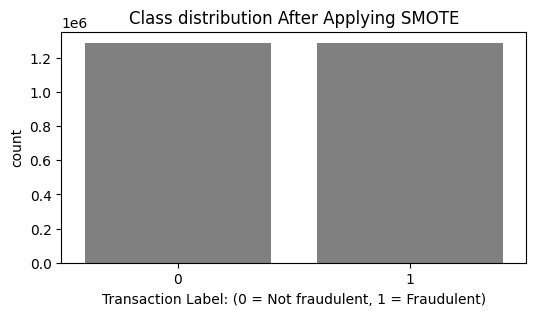

In [15]:
# apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# plot the label/class distribution of the balanced training data
resampled_train_data = pd.concat([X_resampled, pd.Series(y_resampled)], axis=1)
plt.figure(figsize=(6,3))
sns.countplot(data=resampled_train_data, x='is_fraud', color='grey')
plt.title("Class distribution After Applying SMOTE")
plt.xlabel("Transaction Label: (0 = Not fraudulent, 1 = Fraudulent)")
plt.ylabel("count")
plt.show()

**NOVEL APPROACH TO CARD FRAUD PREDICTION:**

**STEP 1:**
**Pre-Filter Features Using Filter Methods**
.
.
.

In [17]:
# Step 1: Filter the preprocessed data through Univariate ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k=10)  # Top 5 features
X_train_anova = selector_anova.fit_transform(X_resampled, y_resampled)
anova_selected = X_train.columns[selector_anova.get_support()]

# Step 2: Filter the preprocessed data through Mutual Information filtering method
selector_mi = SelectKBest(score_func=mutual_info_classif, k=5)
X_train_mi = selector_mi.fit_transform(X_resampled, y_resampled)
mi_selected = X_train.columns[selector_mi.get_support()]

# Combine results (union of both methods)
combined_features = list(set(anova_selected) | set(mi_selected))
print(f"Selected features: {combined_features}")

Selected features: ['category', 'Unnamed: 0', 'merchant', 'month', 'dob', 'unix_time', 'first', 'amt', 'hour', 'gender', 'day']


In [46]:
# print top k features selected during features-filtering
print(list(anova_selected))
print(list(mi_selected))

['Unnamed: 0', 'category', 'amt', 'first', 'gender', 'dob', 'unix_time', 'hour', 'day', 'month']
['merchant', 'category', 'amt', 'hour', 'day']


**STEP 2: Train Random Forest on the Filtered Features**
.
.
.

In [21]:
# filter datasets using the combined selected features
X_train_filtered = X_resampled[combined_features]
X_test_filtered = X_test[combined_features]

# train Random Forest
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X_train_filtered, y_resampled)

RandomForestClassifier(n_estimators=15, random_state=42)

In [22]:
# predict the test data
y_pred = rf.predict(X_test_filtered)

# evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
score = rf.score(X_test_filtered, y_test)

# print scores
print(f"accuracy score = {accuracy:.2f}")
print(f"test accuracy = {score:.2f}")

accuracy score = 0.99
test accuracy = 0.99


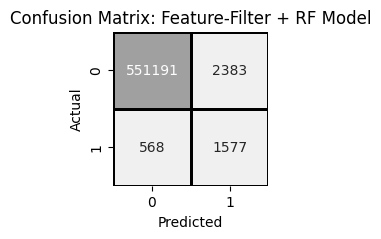

In [44]:
# create a custom light grey colormap
from matplotlib.colors import LinearSegmentedColormap
light_greys = LinearSegmentedColormap.from_list('light_greys', ['#f0f0f0', '#d0d0d0', '#a0a0a0'])

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap=light_greys, cbar=False, linewidths=0.8, linecolor='black')
plt.title('Confusion Matrix: Feature-Filter + RF Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# class_names = ['Not Fraud', 'Fraud']
# plt.xticks(ticks=[0.5, 1.5], labels=class_names)
# plt.yticks(ticks=[0.5, 1.5], labels=class_names, rotation=0)
plt.show()

In [45]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.40      0.74      0.52      2145

    accuracy                           0.99    555719
   macro avg       0.70      0.87      0.76    555719
weighted avg       1.00      0.99      1.00    555719



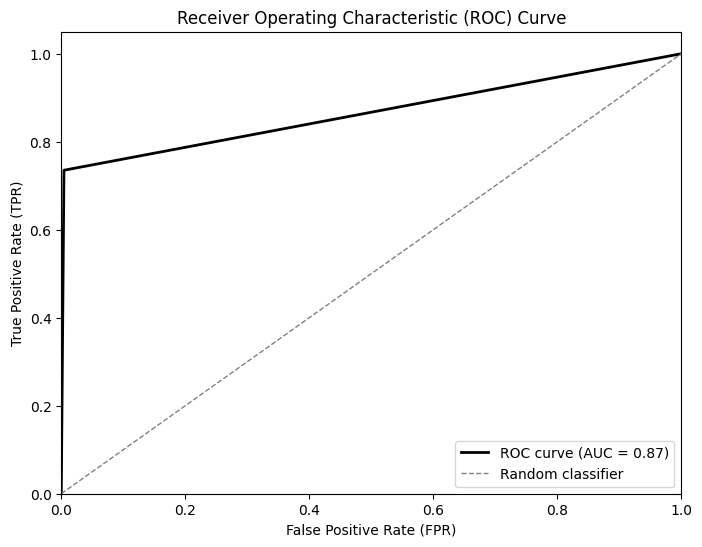

In [56]:
# plot ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# determine the auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
# plt.grid()
plt.show()

**STEP 3: Train and evaluate a RF Classifier without using features filter**
.
.
.

In [48]:
# train the Baseline RF Model
rf_baseline = RandomForestClassifier(n_estimators=15, random_state=42)
rf_baseline.fit(X_resampled, y_resampled)

# predict the test data
y_pred_baseline = rf_baseline.predict(X_test)

# evaluate model performance
print(f"Baseline RF Test Accuracy = {rf_baseline.score(X_test, y_test):.2f}")

Baseline RF Test Accuracy = 1.00


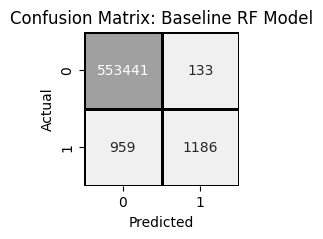

In [49]:
# plot confusion matrix the baseline RF's performance
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(2,2))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap=light_greys, cbar=False, linewidths=0.8, linecolor='black')
plt.title('Confusion Matrix: Baseline RF Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
# print classification report for the Baseline RF Model
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.55      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.78      0.84    555719
weighted avg       1.00      1.00      1.00    555719



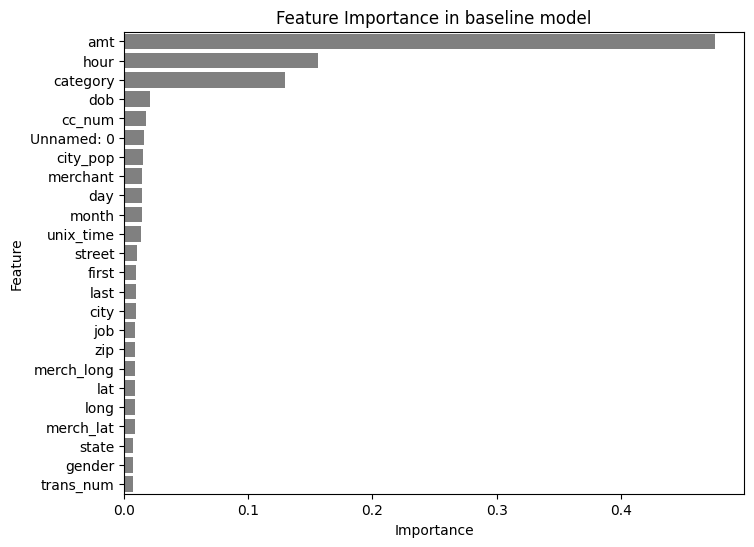

In [58]:
# extract feature importance from the baseline model
feature_importance = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': rf_baseline.feature_importances_
}).sort_values(by='Importance', ascending=False)

# plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='gray')
plt.title('Feature Importance in baseline model')
plt.show()